<font size='6'><b><center>Appendix B</center></b></font>
<font size='6'><b><center>MCMC Theoretical Toy Model</center></b></font>

The following two cells enable automatic equation numbering for this document using <a href="https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/equation-numbering/readme.html"> MathJax </a>.

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [3]:
fig_num = 1

# Fundamental problem

Observing a galaxy's line luminosity with a single-dish telescope, we can represent this value as a weighted sum over several molecular clouds. If we say these clouds fall into $m$ cloud categories and we are observing $n$ molecular emission lines, the ($m\times{}n$)-dimensional cloud luminosity can be represented by $\hat{L}_{\text{cloud}}$ and the $n$-dimensional galaxy luminosity can be represented as $\vec{L}_{\text{gal}}$. Thus, the galaxy's line luminosity in emission line $j$ can be expressed as

\begin{equation}
{L}_{\text{gal},\,j} = 
    {L}_{\text{a},\,j} \cdot w_\text{a}+
    \ldots+
    {L}_{m,\,j} \cdot w_m \quad ,
\end{equation}

or as

\begin{align}
\vec{L}_{\text{gal}} &= 
    \sum_{i}^m \vec{L}_i \cdot w_i \\
    & = \hat{L}_{\text{cloud}} \cdot \vec{w} \quad , 
    \label{eq:main_eq}
\end{align}

where $\vec{w}$ is an $m$-dimensional vector representing the weight for each molecular cloud category. Thus, our question is *if the galaxy luminosity $\vec{L}_{\mathrm{gal}}$ and molecular cloud luminosity $\hat{L}_{\text{cloud}}$ are known, can we determine the weight $w_i$ that each cloud category has on the combined signal?*

Here, we approach this question as a theoretical Bayesian linear regression problem, where we rely on the Markov Chain Monte Carlo (MCMC) technique with `pymc3`. Using this method, the weight parameters to which the model eventually converges ($\vec{w}_{\mathrm{model}}$) should approximate the synthetic weights we generate ($\vec{w}_{\mathrm{obs}}$).

While this problem can be approached deterministically with numerical optimization (see Appendix A), it is not a favorable method. Since we are dealing with a high-dimensional parameter space, it is likely for deterministic methods to get stuck in local minima or maxima. By treating the problem as a sampling task, MCMC methods can more efficiently explore a parameter space, reach convergence to $\vec{w}_{\text{model}} \approx \vec{w}_{\text{obs}}$, and provide uncertainties for $\vec{w}_{\text{model}}$.

# Setting up the model

This document utilizes <a href="https://numpy.org/doc/stable/"> NumPy</a>, <a href="https://docs.python.org/3/library/math.html"> math</a>, <a href="https://matplotlib.org/stable/index.html"> Matplotlib</a>, <a href="https://www.pymc.io/projects/docs/en/v3/index.html"> PyMC3</a>, <a href="https://python.arviz.org/en/stable/"> ArviZ</a>, and <a href="https://corner.readthedocs.io/en/latest/"> corner.py</a> libraries.

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import corner
import warnings # removing warnings
warnings.filterwarnings('ignore')

# plotting specifications
from cycler import cycler
plt.rc('axes',prop_cycle=(cycler('color', ['k','b','g','r','c','m','y'])))
plt.rcParams['text.usetex']= True
plt.rcParams['mathtext.fontset']= 'custom'
plt.rcParams['mathtext.default']= 'rm'
plt.rcParams['axes.formatter.use_mathtext']=False
#----------------------------------------
plt.rcParams['font.size']= 15.0
plt.rcParams['axes.labelsize']= 16.0
plt.rcParams['axes.unicode_minus']= False
plt.rcParams['xtick.major.size']= 6
plt.rcParams['xtick.minor.size']= 3
plt.rcParams['xtick.major.width']= 1.5
plt.rcParams['xtick.minor.width']= 1.0
plt.rcParams['axes.titlesize']= 20 
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize']= 20 
plt.rcParams['ytick.major.width']= 2.0 
plt.rcParams['ytick.minor.width']= 1.0 

%matplotlib inline

First, we generate synthetic observations satisfying Eq. $\ref{eq:main_eq}$. Sampling ${w}_{i}$ and ${L}_{i,\,j}$ from random instances within [0,1], we produce ${L}_{\mathrm{gal},\,j}$. Measurement uncertainties $\delta {L}_{i,\,j}$ and $\delta {L}_{\mathrm{gal},\,j}$ are sampled from random instances of a normal distribution with a standard deviation of 0.1, corrupting ${L}_{i,\,j}$ and ${L}_{\mathrm{gal},\,j}$. These corruptions are added as

\begin{equation}
{\hat{L}_{\mathrm{cloud,\ obs}} = \hat{L}_{\mathrm{cloud}} + \delta \hat{L}_{\mathrm{cloud}}} \quad \text{and} \label{eq:likelihood_one_eq}
\end{equation}

\begin{equation}
{\vec{L}_{\mathrm{gal,\ obs}} = \vec{L}_{\mathrm{gal}} + \delta \vec{L}_{\mathrm{gal}}} \quad . \label{eq:likelihood_two_eq}
\end{equation}

Values for $m$ and $n$ are realistically defined for a given observation (5 cloud categories would reasonably be found within a ~100 pc region of a galaxy). However, the synthetic observations are not necessarily realistic, as luminosity signals normally vary within a broader range of values than [0,1]. In this work, we use small values to serve as a toy model approach to the theoretical problem. 

In [5]:
np.random.seed(55) # reproducible results
m = 5              # number of molecular cloud categories
n = 15             # number of emission lines

# true values
weights_true = np.random.uniform(0, 1, size=m)
cloud_luminosity = np.random.uniform(0, 1, size=(m,n))
gal_luminosity = np.dot(weights_true, cloud_luminosity) 

# known uncertainty
cloud_sd = 0.1
gal_sd = 0.1
cloud_err = np.random.normal(0, cloud_sd, size=(m,n))
gal_err = np.random.normal(0, gal_sd, size=n)

# observations 
cloud_obs = cloud_luminosity + cloud_err
gal_obs = np.dot(weights_true, cloud_obs) + gal_err

Using the `pymc3` package, we create an instance of the `pm.Model()` object, which is assigned to a variable called `model`.

In [6]:
model = pm.Model()

Modifying our `model` instance, a prior distribution is created with assumptions about the unobserved parameters. Our model should encode a hypothesis about how our observations are generated, which in this case is identical to the generation of our synthetic data. Thus, $\vec{w}_{\mathrm{model}}$ and the cloud luminosity $\hat{L}_{\text{cloud}}$ are initialized in the same manner (uniformly within the range [0,1]) as our observations.

In [7]:
with model:
    # ----PRIORS----
    weights = pm.Uniform('weights', 
                         lower=0, 
                         upper=1, 
                         shape=m
                        )
    cloud_luminosity_mu = pm.Uniform('cloud_luminosity_mu', 
                                     lower=0, 
                                     upper=1, 
                                     shape=(m,n)
                                    )

Next, two likelihood functions (Eq. \ref{eq:likelihood_one_eq} and Eq. \ref{eq:likelihood_two_eq}) are defined within our model, in which Eq. $\ref{eq:likelihood_two_eq}$ calls the output of Eq. $\ref{eq:likelihood_one_eq}$. This ensures our measurement uncertainties $\delta \hat{L}_{\mathrm{cloud}}$ and $\delta \vec{L}_{\mathrm{gal}}$ are both accounted for in the determination of $\vec{w}_{\mathrm{model}}$.

In [8]:
with model:
    # ----LIKELIHOOD FUNCTIONS----
    cloud_luminosity_obs = pm.Normal('cloud_luminosity_obs', 
                                     mu=cloud_luminosity_mu, 
                                     sd=cloud_sd, 
                                     shape=(m,n),
                                     observed=cloud_obs
                                    )
    gal_luminosity_obs = pm.Normal('gal_luminosity_obs', 
                                   mu=pm.math.dot(weights, cloud_luminosity_obs), 
                                   sd=gal_sd, 
                                   shape=n, 
                                   observed=gal_obs
                                  )

To analyze the accuracy of $\vec{w}_{\mathrm{model}}$, we calculate the percent error between the observed weight vector $\vec{w}_{\mathrm{obs}}$ and model weight vector $\vec{w}_{\mathrm{model}}$ as a vector $\vec{w}_\mathrm{err}$, where

\begin{equation}
w_{\mathrm{err},\ i} = {{|w_{\mathrm{model},\ i}-w_{\mathrm{obs},\ i}|} \over {w_{\mathrm{obs},\ i}}} \quad . \label{eq:error_eq}
\end{equation}

An evaluation metric (e.g. mean, median, or maximum) term `eval_metric` is applied to the error vector $\vec{w}_\mathrm{err}$ outputted by Eq. \ref{eq:error_eq}, resulting in a single representative error value.

In [9]:
def getPercentError(original, test, eval_metric):
    '''
    SUMMARY:
    Applies specified percent error metric to weights

    PARAMETERS:
    original (arr): initial weight vector
    test (arr): new weight vector
    evaluation_metric (str): specified statistical metric
    '''
    absolute = np.absolute(np.subtract(test, original))
    divided_absolute = np.divide(absolute, original) * 100

    if eval_metric == "mean":
        averaged_divided_absolute = np.average(divided_absolute)
    elif eval_metric == "max":
        averaged_divided_absolute = np.amax(divided_absolute)
    else:
        averaged_divided_absolute = np.median(divided_absolute)
    return averaged_divided_absolute

# Testing the model

To test our model, MCMC samples from a random distribution and eventually converges to the stationary (model) distribution. Since we do not want to collect samples while the model is still reaching convergence, `tune` and `draws` terms are defined. By setting `tune` to a number, we require the Markov chain to converge to the stationary distribution for that given number of iterations before collecting any `draws`. Thus, only samples taken during the `draws` period are kept. However, sometimes the Markov chain does not converge within the given number of samples (`tune` + `draws`). To check for convergence, we run multiple `chains` simultaneously to ensure the parameter space is well explored. Each chain starts from a different initial state and independently explores different regions of the parameter space.

An MCMC algorithm is specified to collect these samples. However, it's worth noting that not all algorithms use the same method of exploration. For instance, the Metropolis-Hastings algorithm utilizes "random walk" behavior, where a proposed exploration of a new point within a given parameter space is made by perturbing the current point randomly. This method is effective for exploring low-dimensional parameter spaces. 

In this work, the No-U-Turn Sampler (NUTS) method is used. This is a more sophisticated algorithm which avoids random walk. It uses Hamiltonian dynamics to propose explorations, by adaptively tuning the step size and direction of motion. It also detects if the future trajectory will turn back on itself, effectively avoiding over-exploration of areas in the parameter space.

Below, we set the model to burn through 5,000 `tune` samples, collect 10,000 `draws`, and run 3 `chains` using the NUTS sampler.

In [10]:
with model:
    # ----SAMPLING----
    trace = pm.sample(draws=10000,
                      tune=5000,
                      chains=3,
                      return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [cloud_luminosity_mu, weights]


Sampling 3 chains for 5_000 tune and 10_000 draw iterations (15_000 + 30_000 draws total) took 19 seconds.


Here, we save our results from the posterior as variables, display the summary of the trace for each weight $w_{\mathrm{model},\ i}$, and calculate the mean value of our error vector $\vec{w}_\mathrm{err}$. 

In [11]:
weights = trace.posterior.weights
weight_vals = trace.posterior.weights.values

weights_predicted = []
weight_predicted_err = []
for i in range(m):
    weights_predicted.append(np.mean(weight_vals[:,:,i]))
    weight_predicted_err.append(np.std(weight_vals[:,:,i]))

In [12]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
weights[0],0.162,0.072,0.022,0.289,0.000,0.0,28026.0,13182.0,1.0
weights[1],0.914,0.057,0.815,1.000,0.000,0.0,29504.0,16344.0,1.0
weights[2],0.420,0.069,0.290,0.550,0.000,0.0,39685.0,20255.0,1.0
weights[3],0.245,0.086,0.084,0.407,0.000,0.0,34814.0,14766.0,1.0
weights[4],0.535,0.067,0.411,0.664,0.000,0.0,43606.0,20955.0,1.0
...,...,...,...,...,...,...,...,...,...
"cloud_luminosity_mu[4,10]",0.732,0.099,0.549,0.921,0.001,0.0,26019.0,10922.0,1.0
"cloud_luminosity_mu[4,11]",0.799,0.093,0.636,0.981,0.001,0.0,28076.0,12738.0,1.0
"cloud_luminosity_mu[4,12]",0.091,0.066,0.000,0.206,0.000,0.0,27935.0,15146.0,1.0
"cloud_luminosity_mu[4,13]",0.869,0.081,0.732,1.000,0.000,0.0,24971.0,11887.0,1.0


In [13]:
print('Mean Error:', 
      round(getPercentError(weights_true, weights_predicted, 'mean'),2),'%')
print('Median Error:', 
      round(getPercentError(weights_true, weights_predicted, 'median'),2),'%')

Mean Error: 19.07 %
Median Error: 5.96 %


For this model, the mean error as calculated in Eq. $\ref{eq:error_eq}$ is ~19% and the median error is ~6%. For comparison, numerical optimization performed in Appendix A under similar conditions ($m$ = 5, $n$ = 15, and standard deviations of 0.1) yielded a consistent median error of ~30%. 

# Posterior analysis

Fig. 1: weight traces

weight 1 : 0.1623


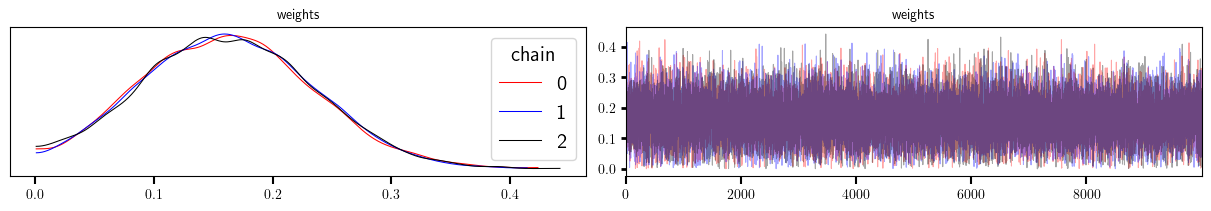

weight 2 : 0.9138


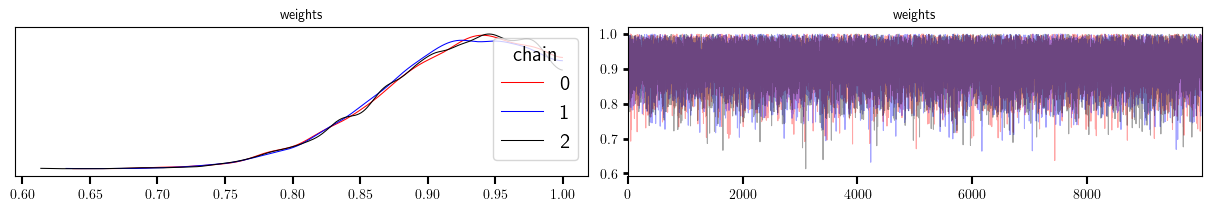

weight 3 : 0.4195


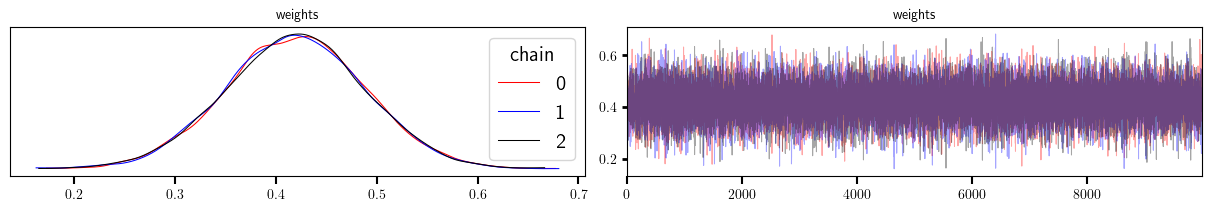

weight 4 : 0.2453


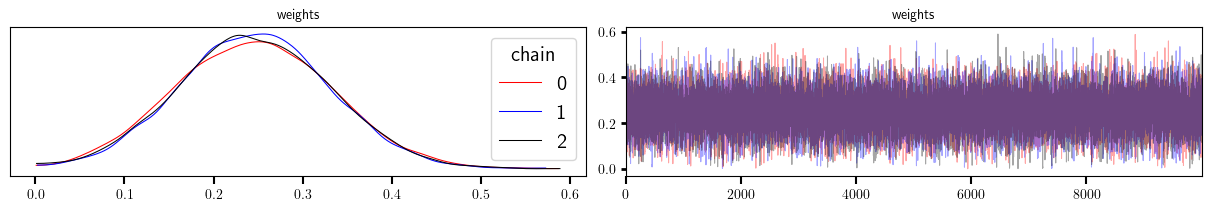

weight 5 : 0.5345


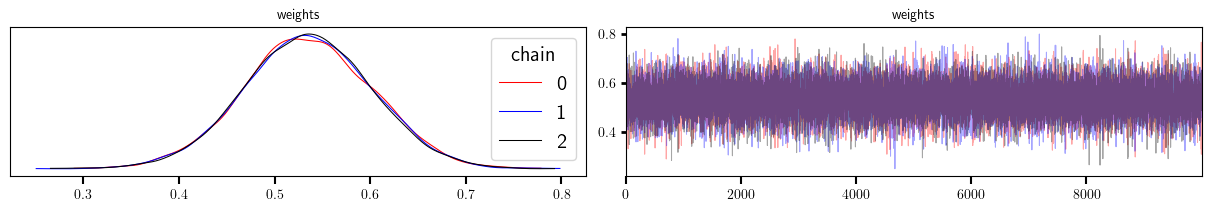

In [14]:
print(f'Fig. {fig_num}: weight traces',end='\n\n')
for i in range(weight_vals.shape[2]):
    print('weight',i+1,':',np.round(weights_predicted[i],4))
    az.plot_trace(weights[:,:,i],
                  chain_prop={'color': ['C3','C1','C7']},
                  legend=True
                 )
    plt.show()
fig_num += 1

In Fig. 1, the left column consists of the marginal posterior densities for each parameter and the right column consists of our sample collection. A marginal posterior density represents the probability distribution of a single parameter, where "marginal" refers to integrating out all other parameters to focus on the distribution of interest.

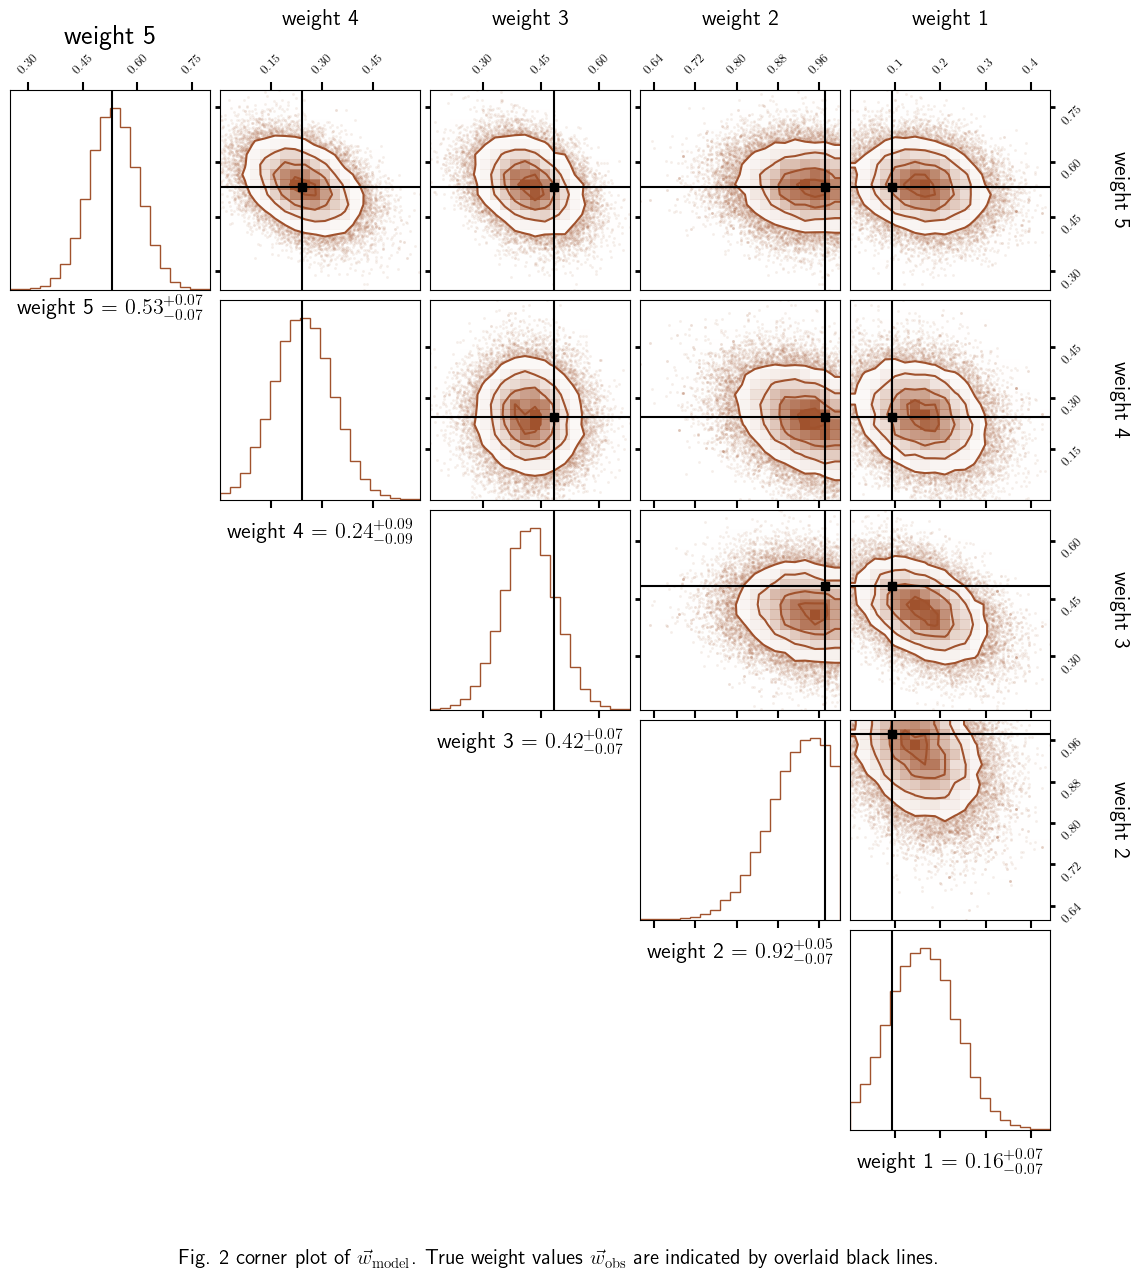

In [15]:
fig = corner.corner(trace, 
                    var_names=['weights'],
                    labels=[r'weight 1', r'weight 2',r'weight 3',r'weight 4',r'weight 5'],
                    truths=dict(weights=weights_true),
                    color='sienna',
                    truth_color='black',
                    show_titles=True,
                    reverse=True)
# labelsize of x,y-ticks:
for ax in fig.get_axes(): 
      ax.tick_params(axis='both', labelsize=9)
# include figure caption
fig_name = f'Fig. {fig_num} ' + r'corner plot of $\vec{w}_{\mathrm{model}}$. True weight values $\vec{w}_{\mathrm{obs}}$ are indicated by overlaid black lines.'
fig.text(.5, -.08, fig_name, fontsize=15, ha='center')
plt.show()
fig_num += 1

In Fig. 2, the histograms on the diagonal show the marginalized posterior densities for each parameter. The contour plots show the correlation among parameters. The contour levels are defined as (0.5, 1, 1.5, 2)-sigma equivalent, containing 11.8%, 39.3%, 67.5%, 86.4% of the samples. This is explained in more detail in the `corner.corner()` <a href='https://corner.readthedocs.io/en/latest/pages/sigmas/'>sigmas documentation</a>.

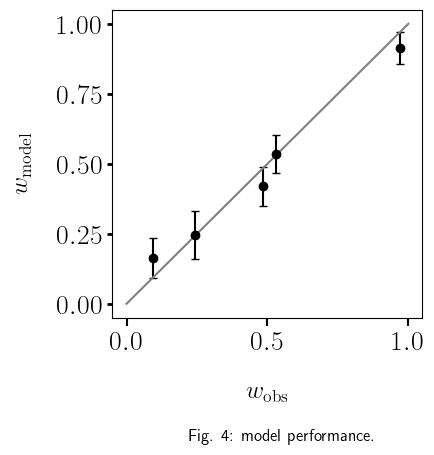

In [19]:
x = np.linspace(0,1,2)
fig = plt.figure(figsize=(4,4))
for cloud in range(m):
    plt.errorbar(weights_true[cloud], 
                 weights_predicted[cloud], 
                 yerr=weight_predicted_err[cloud],
                 marker='o',
                 capsize=3,
                 color='black'
                )
plt.plot(x, x, color='grey')
plt.xlabel(r'$w_{\mathrm{obs}}$',fontsize=18, labelpad=18)
plt.ylabel(r'$w_{\mathrm{model}}$',fontsize=18, labelpad=18)
# include figure caption
fig_name = f'Fig. {fig_num}: model performance.'
fig.text(.55, -.2, fig_name, fontsize=12, ha='center')
plt.show()
fig_num += 1

Fig. 3 demonstrates our model's performance by directly comparing $\vec{w}_{\mathrm{obs}}$ and $\vec{w}_{\mathrm{model}}$. The expected slope value for the scatter is shown by the grey solid line. The standard deviation for each weight probability is represented by error bars. When accounting for uncertainties outputted by MCMC, each data point falls within the expected slope.